## Laboratorium 8.1


## Metody wykrywania ruchu: przepływ optyczny (_optical flow_)

### Wstęp

Na poprzednich laboratoriach poznaliśmy podstawowe metody przetwarzania obrazów, a więc dwuwymiarowych sygnałów przestrzennych. Wiele z tych metod działa także dla (trójwymiarowego) sygnału wideo, jeśli - nieco naiwnie - potraktujemy go jako po prostu sekwencję niezależnych obrazów.

W tej liście wykorzystasz także dziedziną czasową do przetwarzania sygnału. Podstawowa intuicja polega na tym, że jeśli jakiś rejon obrazu przesunął się w czasie, to prawdopodobnie ma on inne _znaczenie_ niż rejon, który pozostał w tym samym miejscu, lub przesunął w innym kierunku czy z inną szybkością. Jeśli zatem jesteśmy w stanie wykryć to przesunięcie - czyli po prostu _ruch_ - to otrzymamy pewną informację o zawartości obrazu (wideo). Na przykład, będziemy w stanie oddzielić poruszające się obiekty od stacjonarnego tła, albo oddzielić inaczej poruszające się obiekty.

Jedną z najpowszechniejszych metodą do automatycznej detekcji ruchu jest znana Ci już z wykładu metoda przepływu optycznego (ang. _optical flow_). Namawiam też do lektury [artykułu z dokumentacji OpenCV](https://docs.opencv.org/3.4/d4/dee/tutorial_optical_flow.html), zwłaszcza sekcji _Lucas-Kanade_ oraz _Dense Optical Flow_. Analizując kod metody, poświęć chwilę na zrozumienie mapowania wyników do prezentowanego obrazu w przestrzeni HSV.

Wiedzieć należy na pewno, że istnieją dwie główne odmiany metody przepływu optycznego:,
* przepływ gęsty (_dense_) - gdzie przesunięcie pomiędzy klatkami określane jest dla każdego piksela (na tej metodzie skupia się niniejsza część listy),
* przepływ rzadki (_sparse_) - gdzie ruch wykrywany jest tylko dla pewnego zbioru punktów zainteresowania w obrębie obrazu (przebadasz ją w drugiej części listy).

W ramach obu odmian występuje pewna liczba konkretnych metod obliczeniowych, w zależności od konkretnego podejścia do rozwiązywania równania ruchu. Na tych zajęciach wykorzystamy [algorytm Farnebacka](http://www.diva-portal.org/smash/get/diva2:273847/FULLTEXT01.pdf) - głównie dlatego, że jego gotowa implementacja znajduje się w pakiecie OpenCV.

### Podejście

Większość algorytmów optical flow operuje na parze klatek, znajdując wektory translacji pomiędzy rejonami z jednej i drugiej. Jeśli więc interesuje nas przetwarzanie ciągłego strumienia wideo, praca przebiegać będzie na zasadzie dwuelementowej kolejki, tzn. zawsze patrzymy na klatkę obecną $I(x,y,t)$ i poprzednią $I(x,y,t-1)$.

OpenCV oferuje banalnie prosty a zarazem potężny interfejs do obsługi strumieni wideo: [`cv2.VideoCapture`](https://docs.opencv.org/3.4/d8/dfe/classcv_1_1VideoCapture.html), za pomocą którego w ten sam sposób możemy obsługiwać pliki wideo w różnym kodowaniu, urządzenia wideo (np. kamerkę w laptopie) czy nawet wideo w protokole IP (choć występują pewne różnice z punktu widzenia użycia, jeśli korzystamy z zasobu sprzętowego działającego w czasie rzeczywistym). Idea jest prosta:
* tworzymy obiekt `cv2.VideoCapture` w odpowiedni sposób,
* pobieramy poszczególne klatki za pomocą metody [`VideoCapture::read`](https://docs.opencv.org/3.4/d8/dfe/classcv_1_1VideoCapture.html#a473055e77dd7faa4d26d686226b292c1).

Metoda `read` wykonuje całą pracę (odczytanie danych, dekodowanie strumienia wideo) i zwraca klatkę jako obraz w standardowym formacie OpenCV (a także flagę, czy w ogóle udało się pozyskać dane - krotka (flaga, klatka)). Zatem, aby pozyskać pierwszą klatkę z pliku wideo wystarczy:
```python
vid = cv2.VideoCapture("back.mp4")
r, frame = vid.read()
```

Drobnym ograniczeniem VideoCapture jest to, że nie ma możliwości cofnięcia się do poprzednio pobranej klatki (co jest naturalne w przypadku korzystania z fizycznego urządzenia do akwizycji, a może trochę mniej gdy czytamy z pliku). Jeśli potrzebny jest powrót do początku pliku wideo, niestety konieczne jest zamknięcie strumienia (`VideoCapture::release`) i ponowne otwarcie (`::open`).

Aby obliczyć (gęsty) przepływ optyczny pomiędzy dwiema klatkami, wykorzystamy algorytm Farnebacka, zaimplementowany w OpenCV w funkcji [`cv2.calcOpticalFlowFarneback`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga5d10ebbd59fe09c5f650289ec0ece5af). Przyjmuje ona parę obrazów **w skali szarości**, opcjonalny argument `flow` (rozwiązanie można zainicjować poprzednio wyliczonym przepływem, jeśli nim dysponujemy), a następnie szereg parametrów sterujących metodą; m.in. można wykorzystać piramidyzację obrazów (rekomendowane `pyr_size` $=3$) czy określić rozmiar okna detekcji `winsize`. Sensowne pierwsze wartości dla argumentów podane są w dokumentacji.

Algorytm Farnebacka zwraca przepływ w formie obrazu o wymiarach przestrzennych równych obrazom wejściowym i dwóch kanałach, zawierających przesunięcie odpowiednio w osi $x$ i $y$. Można więc przetwarzać te dane dalej, np. obliczając kąt przesunięcia czy całkowitą odległość (i dalej, np. określić prędkość ruchu) - vide np. `cv2.cartToPolar`.

---

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Zadanie 1

#### Zadanie 1a
Otwórz wideo `kick.mp4` lub `back.mp4` i pobierz kilka klatek. Przewiń do interesującego Cię momentu - tak, aby uzyskać dwie klatki, na których widać ruch (pro-tip: znając framerate materiału (~25fps) i czas, w którym rozpoczyna się interesujący fragment, możesz w pętli "skonsumować" odpowiednią ilość klatek).  
Wykorzystaj algorytm Farnebacka do obliczenia przepływu pomiędzy klatkami. Wynik zaprezentuj w postaci obrazu całkowitego przesunięcia. W zależności od wybranego momentu w wideo, możesz spodziewać się uzyskania wyraźnych obszarów.

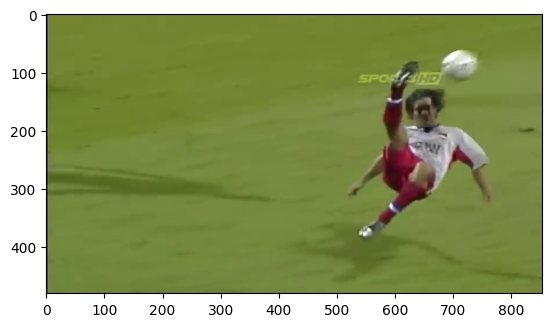

In [24]:
path = "dane/kick.mp4"
cap = cv2.VideoCapture(path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
start_time = 1.4
frame_to_start = int(start_time * fps)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_to_start)
_, frame = cap.read()
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), cmap='gray')

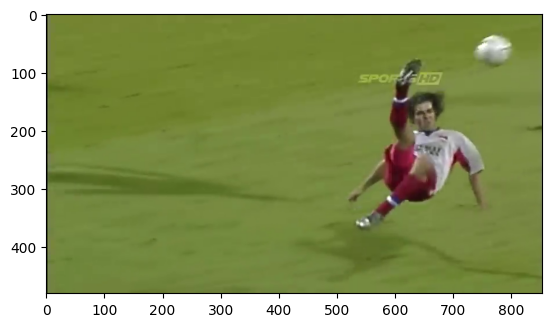

In [25]:
path = "dane/kick.mp4"
cap = cv2.VideoCapture(path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
start_time = 1.5
frame_to_start = int(start_time * fps)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_to_start)
r, frame2 = cap.read()
plt.imshow(cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB), cmap='gray')

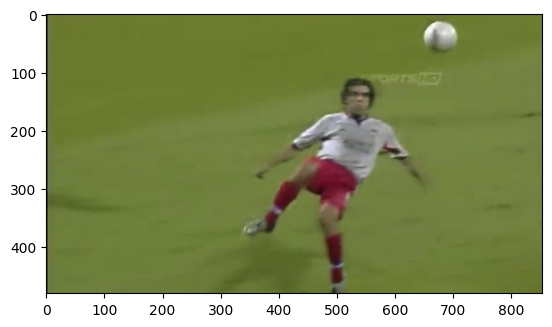

In [4]:
path = "dane/kick.mp4"
cap = cv2.VideoCapture(path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
start_time = 0.5
frame_to_start = int(start_time * fps)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_to_start)
_, frame3 = cap.read()
plt.imshow(cv2.cvtColor(frame3, cv2.COLOR_BGR2RGB), cmap='gray')

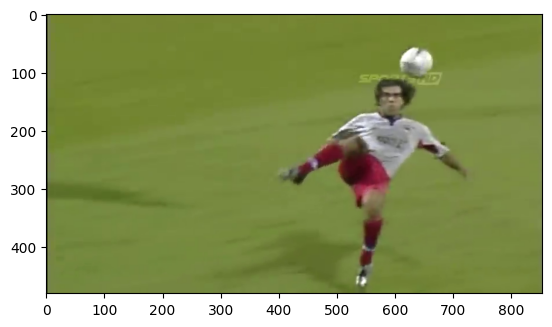

In [5]:
path = "dane/kick.mp4"
cap = cv2.VideoCapture(path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
start_time = 0.8
frame_to_start = int(start_time * fps)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_to_start)
_, frame4 = cap.read()
plt.imshow(cv2.cvtColor(frame4, cv2.COLOR_BGR2RGB), cmap='gray')

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def optic_flow(frame_old, frame_new, flow=None, pyr_scale=0.5, levels=3, winsize=10, iterations=3, poly_n=5, poly_sigma=1.1, flags=0):
    gray_old = cv2.cvtColor(frame_old, cv2.COLOR_BGR2GRAY)
    gray_new = cv2.cvtColor(frame_new, cv2.COLOR_BGR2GRAY)
    
    hsv = np.zeros_like(frame_old)
    hsv[..., 1] = 255
    
    flow = cv2.calcOpticalFlowFarneback(gray_old, gray_new, flow, pyr_scale, levels, winsize, iterations, poly_n, poly_sigma, flags)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    
    hsv[..., 0] = ang * 180 / np.pi / 2  
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    color_wheel = generate_color_wheel()

    fig, axes = plt.subplots(1, 4, figsize=(25, 10))
    
    axes[0].imshow(cv2.cvtColor(frame_old, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Old Frame")
    axes[0].axis("off")

    axes[1].imshow(cv2.cvtColor(frame_new, cv2.COLOR_BGR2RGB))
    axes[1].set_title("New Frame")
    axes[1].axis("off")

    axes[2].imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))
    axes[2].set_title("Optical Flow")
    axes[2].axis("off")

    axes[3].imshow(color_wheel)
    axes[3].set_title("Color Wheel (Flow Directions)")
    axes[3].axis("off")

    plt.show()

def generate_color_wheel():
    size = 300  
    wheel = np.zeros((size, size, 3), dtype=np.uint8)
    center = size // 2
    radius = size // 2

    for y in range(size):
        for x in range(size):
            dx = x - center
            dy = y - center
            distance = np.sqrt(dx**2 + dy**2)

            if distance <= radius:
                angle = np.arctan2(dy, dx) 
                angle = (angle + 2 * np.pi) % (2 * np.pi) 
                hue = angle * 180 / np.pi / 2 

                wheel[y, x, 0] = hue
                wheel[y, x, 1] = 255
                wheel[y, x, 2] = int(255 * (1 - distance / radius))  

    return cv2.cvtColor(wheel, cv2.COLOR_HSV2RGB)

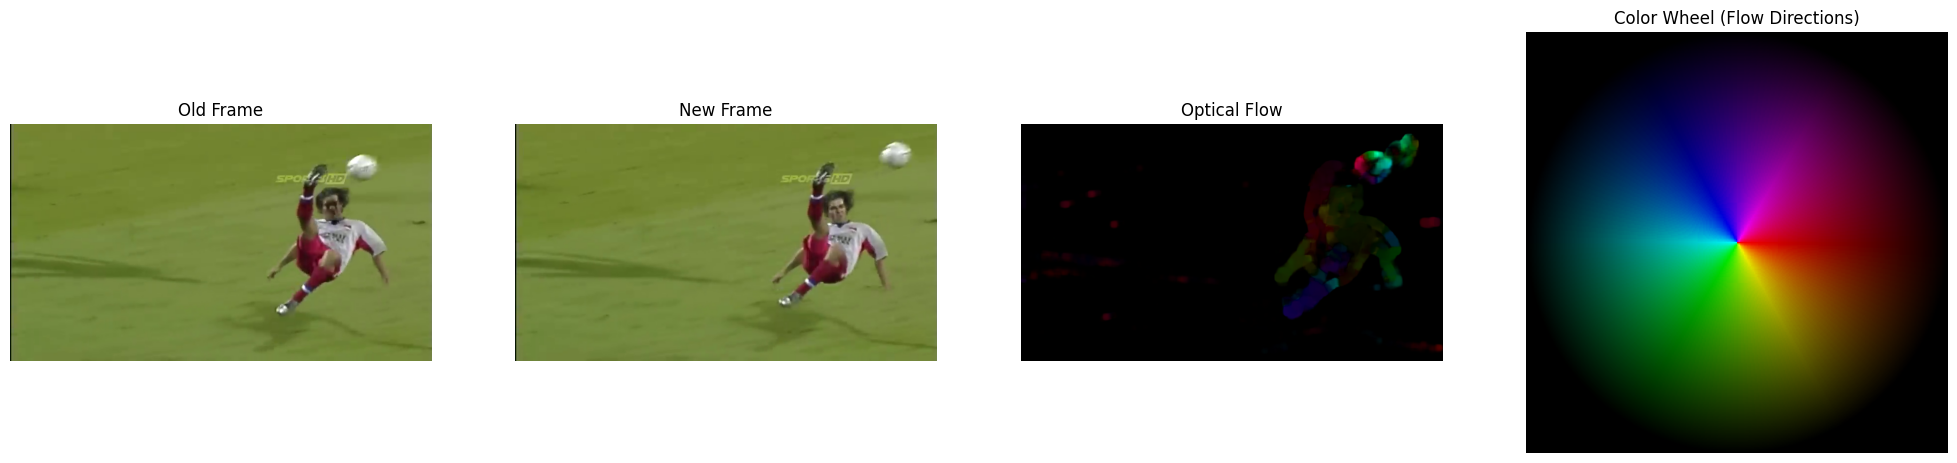

In [7]:
optic_flow(frame, frame2)

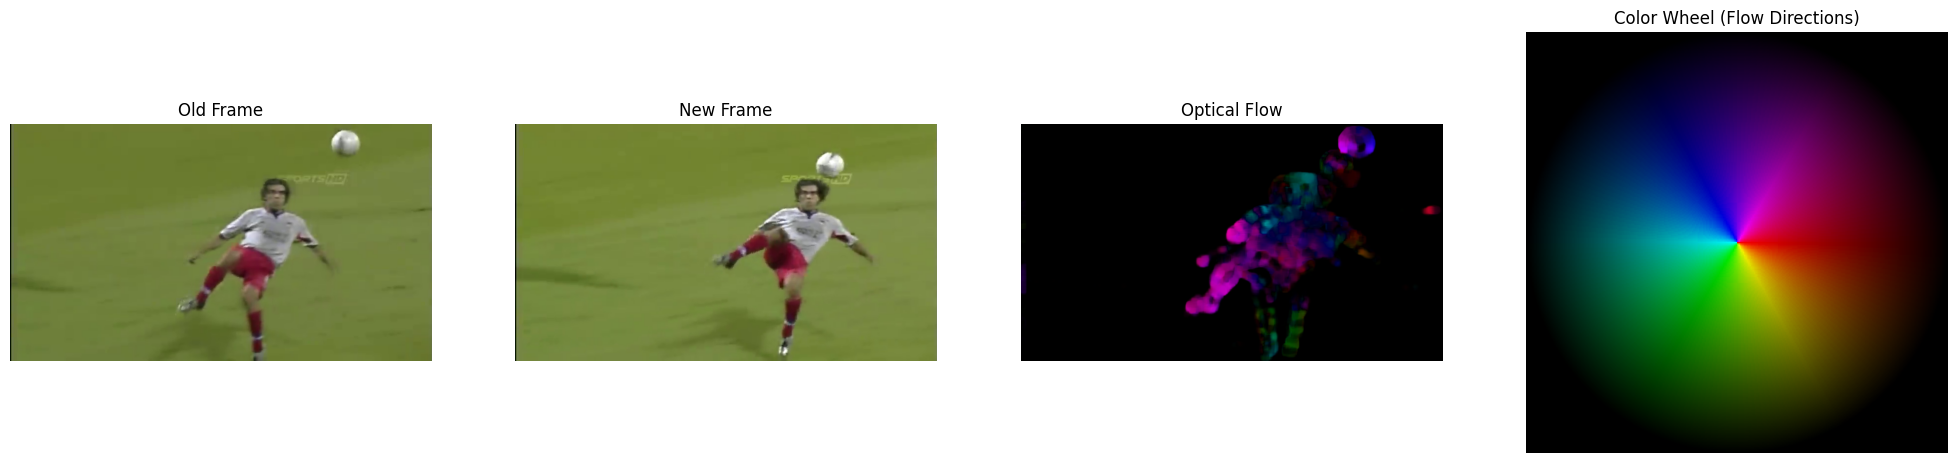

In [8]:
optic_flow(frame3, frame4)

#### Zadanie 1b
Zbadaj wpływ parametru `winsize` na działanie metody.

In [20]:
def optic_flow(frame_old, frame_new, flow=None, pyr_scale=0.5, levels=3, winsize=10, iterations=3, poly_n=5, poly_sigma=1.1, flags=0):
    gray_old = cv2.cvtColor(frame_old, cv2.COLOR_BGR2GRAY)
    gray_new = cv2.cvtColor(frame_new, cv2.COLOR_BGR2GRAY)
    hsv = np.zeros_like(frame_old)
    hsv[..., 1] = 255
    flow = cv2.calcOpticalFlowFarneback(gray_old, gray_new, flow, pyr_scale, levels, winsize, iterations, poly_n, poly_sigma, flags)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang*180/np.pi/2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 10))
    axes[0].imshow(cv2.cvtColor(frame_old, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Old frame")
    axes[0].axis("off")

    axes[1].imshow(cv2.cvtColor(frame_new, cv2.COLOR_BGR2RGB))
    axes[1].set_title("New frame")
    axes[1].axis("off")

    axes[2].imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))
    axes[2].set_title("Optical Flow")
    axes[2].axis("off")

    plt.show()

<Figure size 1200x1200 with 0 Axes>

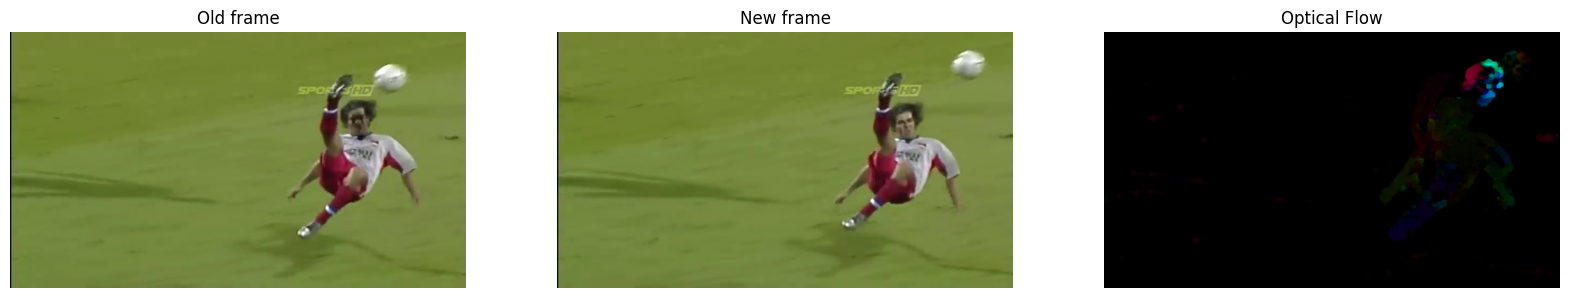

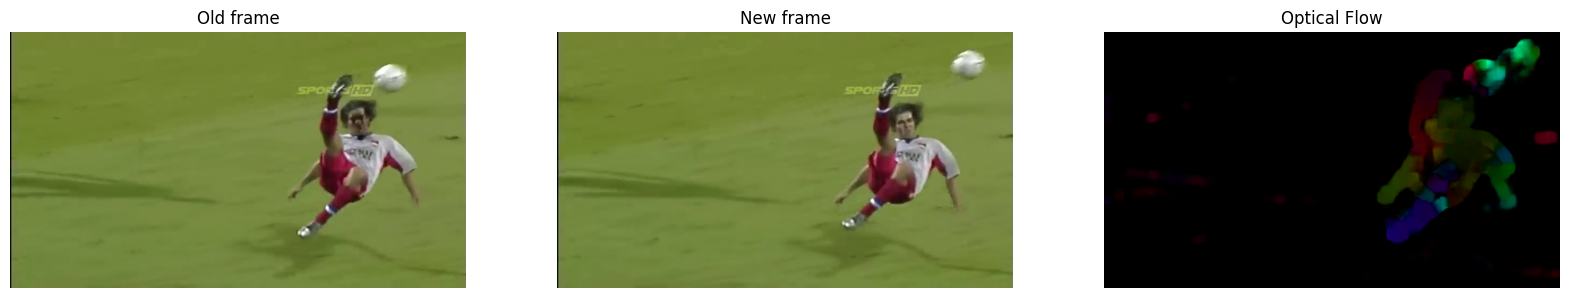

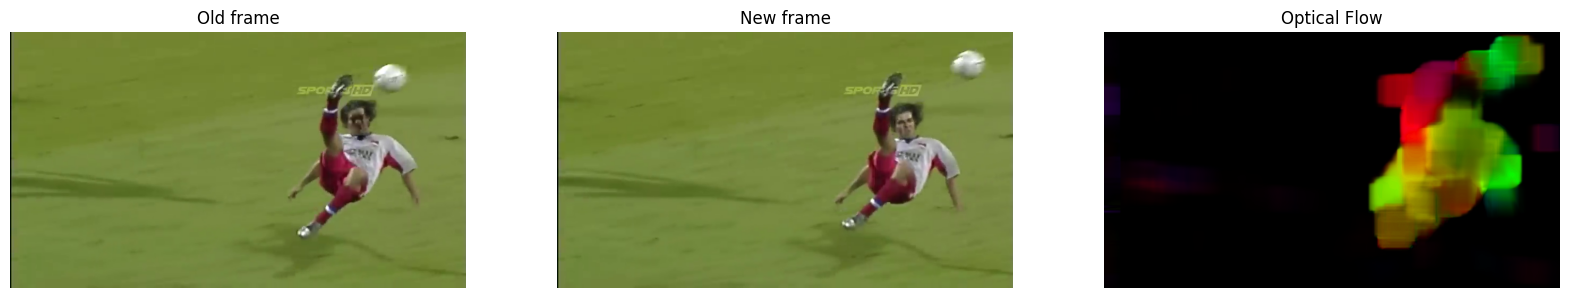

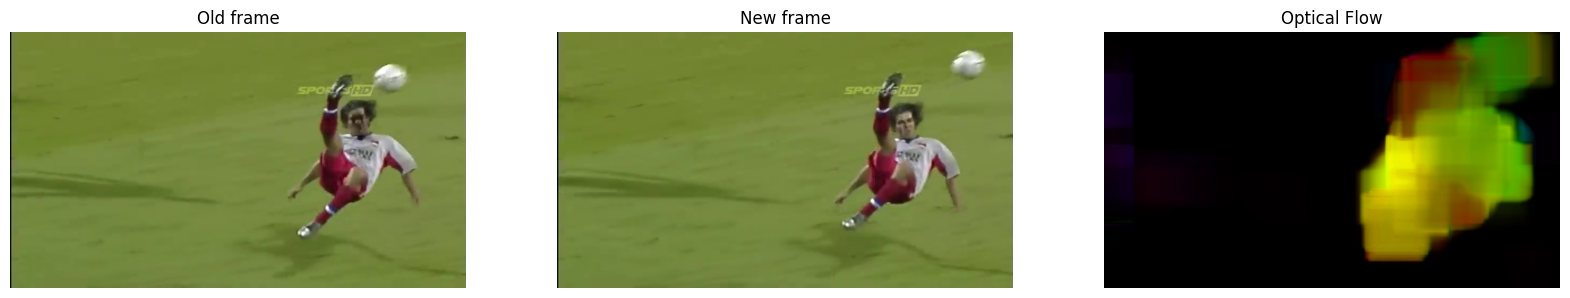

In [29]:
winsizes = [5, 15, 50, 100]

plt.figure(figsize=(12, 12))

for i, winsize in enumerate(winsizes):
    optflow = optic_flow(frame, frame2, winsize=winsize)

Komentarz 1:

...

---

### Zadanie 2

Powtórz powyższy eksperyment na materiale `shot.mp4` (przewiń materiał do momentu natychmiast po uderzeniu białej bili, ok. 20-25 klatek; framerate wynosi tu ok. 15fps).  
*Czy algorytm działa tak samo dobrze? Dlaczego? Co jest ograniczeniem metody?*

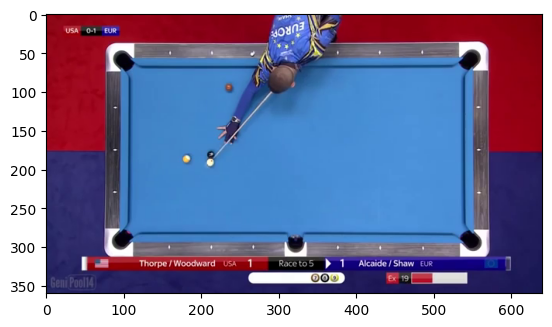

In [11]:
path = "dane/shot.mp4"
cap = cv2.VideoCapture(path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
start_time = 20/fps
frame_to_start = int(start_time * fps)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_to_start)
r, frame_bsl = cap.read()
plt.imshow(cv2.cvtColor(frame_bsl, cv2.COLOR_BGR2RGB), cmap='gray')

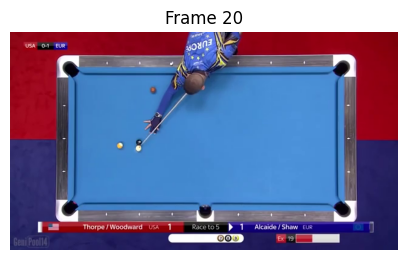

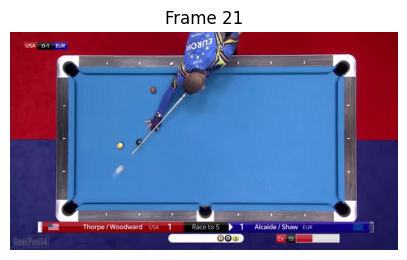

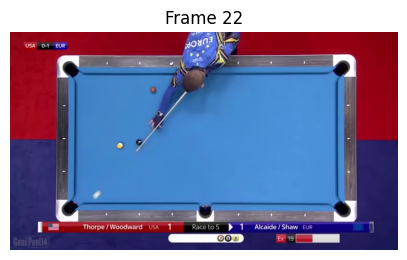

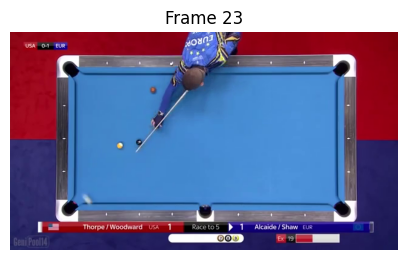

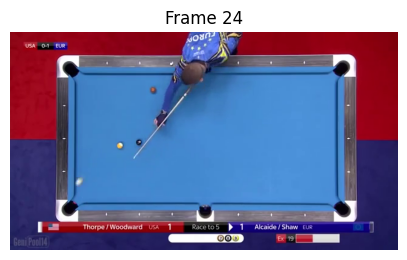

In [12]:
path = "dane/shot.mp4"
cap = cv2.VideoCapture(path)

frames = {}
for i in range(20, 26):
    cap.set(cv2.CAP_PROP_POS_FRAMES, i)  
    ret, frame = cap.read() 
    frames[i] = frame 

fps = int(cap.get(cv2.CAP_PROP_FPS))
start_time = 20 / fps
frame_to_start = int(start_time * fps)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_to_start)

for i in range(20, 25):
    if i in frames:
        plt.figure(figsize=(5, 5))
        plt.imshow(cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB))
        plt.title(f"Frame {i}")
        plt.axis('off')
        plt.show()

cap.release() 


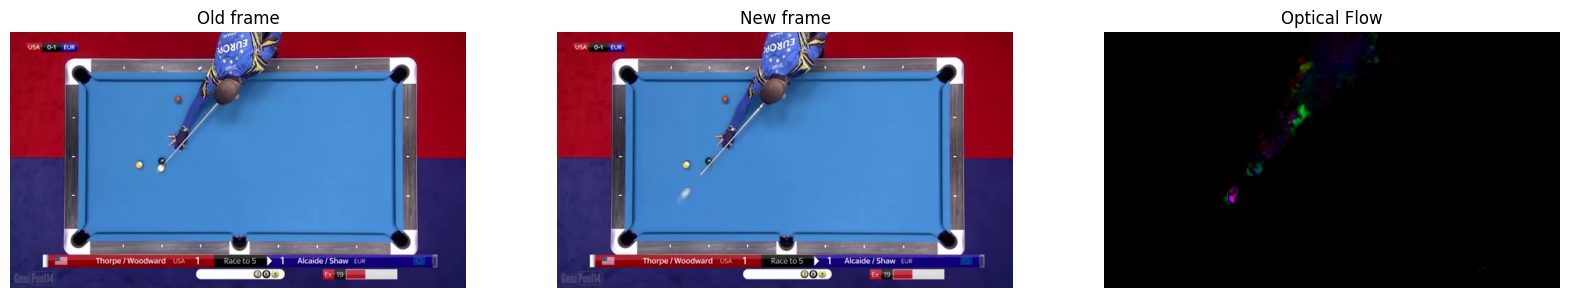

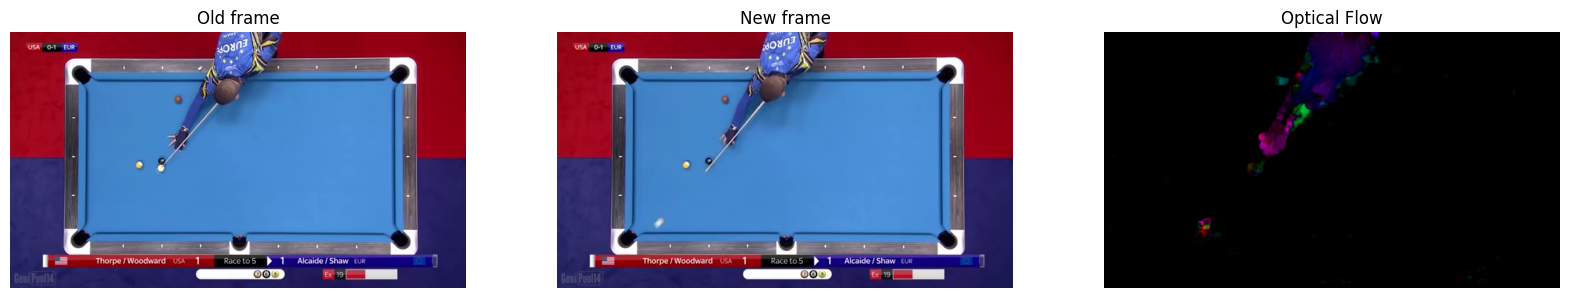

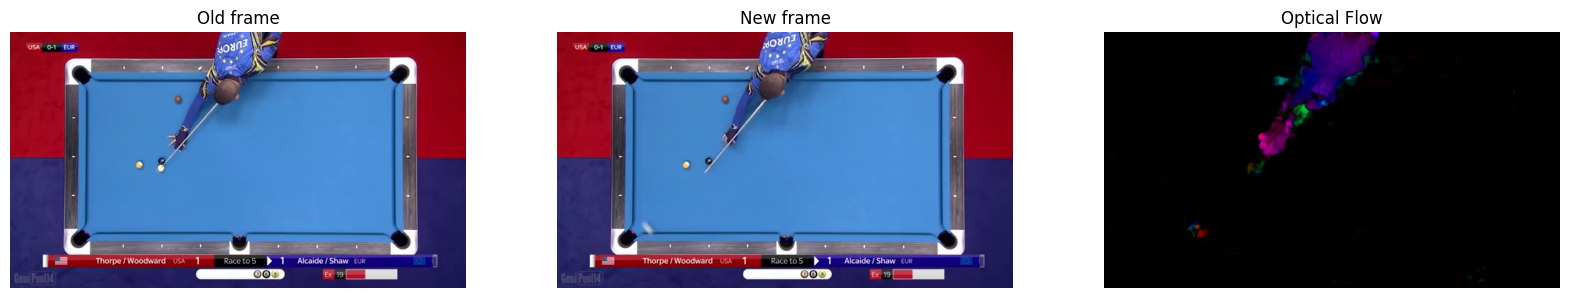

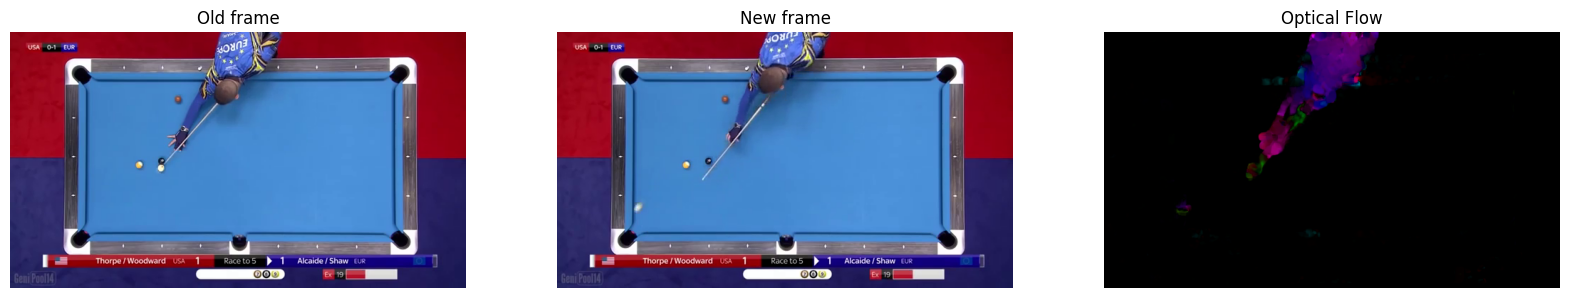

In [13]:
for i in range(20, 24):
    optic_flow(frame_bsl, frames[i+1], winsize=5)

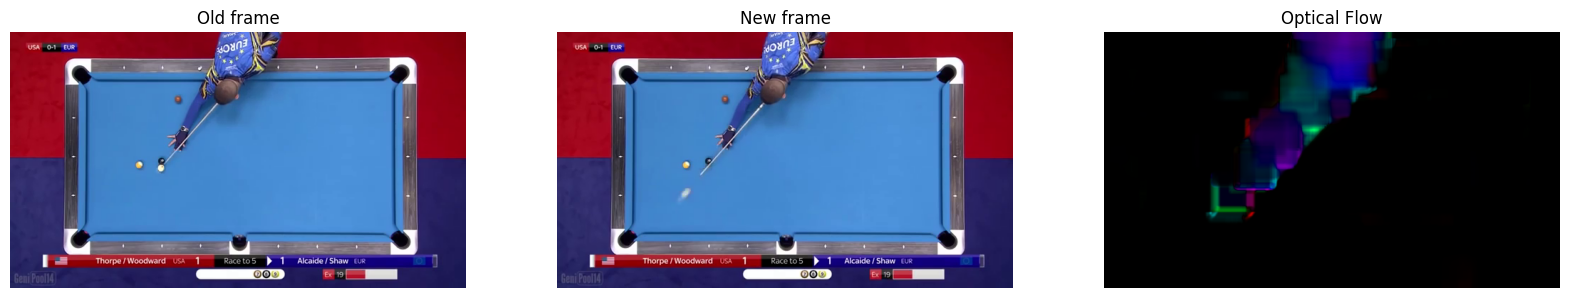

In [31]:
optic_flow(frame_bsl, frames[21], winsize=50)

Komentarz 2:

...

### Zadanie dla chętnych

Powróć do takiego przypadku i konfiguracji algorytmu, dla którego uzyskane przez Ciebie wyniki były satysfakcjonujące. Przypomnij sobie zajęcia dotyczące np. segmentacji i wykorzystaj informację o przepływie optycznym do oddzielenia na obrazie obiektów od tła (metoda zupełnie dowolna).